In [1]:
import os
import time

import numpy as np
import scipy as sp
from scipy import stats as sps
from scipy import linalg
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Dataset loader class for minibatch gradient descent

In [2]:
class Dataset():
    def __init__(self, data_split):
        data = np.load(data_split,allow_pickle=True).item()
        self.supervoxel_interp = data['supervoxel_interp']
        self.Y = data['Y'] #/100 if not zscoring
        self.Y = sps.zscore(self.Y, nan_policy='omit')
        #self.Y[:,0] = ndimage.gaussian_filter1d(self.Y[:,0],sigma=1)
        #self.Y[:,1] = ndimage.gaussian_filter1d(self.Y[:,1],sigma=1)
    def __getitem__(self, index):
        supervoxel = self.supervoxel_interp[index,:]
        y = self.Y[index,:]
        return supervoxel, y
    def __len__(self):
        return len(self.supervoxel_interp)

## Device definition

In [13]:
devices = ['cuda:0', 'cuda:2', 'cuda:3', 'cuda:5']
device = devices[2]

## Dataset io and dataloader initializer

In [4]:
# Learning rate.
ALPHA = 0.01

# Get the data and initialize the dataloader
train_dataset = Dataset('/mnt/fs4/minseung/deepfly/data/prelim/train_data_layer_no_fwd_clip23.npy')
test_dataset = Dataset('/mnt/fs4/minseung/deepfly/data/prelim/test_data_layer_no_fwd_clip23.npy')
BATCH_SIZE = train_dataset.supervoxel_interp.shape[0]
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                         shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                         shuffle=False)

## Linear model

In [14]:
# Simple linear model.
model = nn.Sequential(
          nn.Linear(2000, 2),
        )

# Define the loss function as MSE loss
criterion = nn.MSELoss()

# Define the optimizer with a learning rate
optimizer = optim.Adam(model.parameters(), lr=ALPHA)
model = model.to(device)

## Train linear model

In [15]:
start_time = time.time()

# Number of training epochs
N_EPOCHS = 20
cost_cache = []

for epoch in range(N_EPOCHS): 
    
      for i, (supervoxel, y) in enumerate(train_loader, 0):
        
        supervoxel = supervoxel.float().to(device)
        y = y.float().to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward propogation
        outputs = model(supervoxel)
        
        # calculate the loss
        loss = criterion(outputs, y)
        
        # backpropogation + update parameters
        loss.backward()
        optimizer.step()

        # print statistics
        cost = loss.item()
        cost_cache.append(cost)
        if epoch % 10 == 0 and i % 100 == 0:    # print every 1000 iterations
            print('Epoch:' + str(epoch) + ", Iteration: " + str(i) 
                  + ", training cost = " + str(cost))
            
print("--- %s seconds ---" % (time.time() - start_time))savefig

Epoch:0, Iteration: 0, training cost = 1.022933840751648
Epoch:10, Iteration: 0, training cost = 0.831404447555542
--- 46.617840051651 seconds ---


## Predict training data and get the MSE and MAD

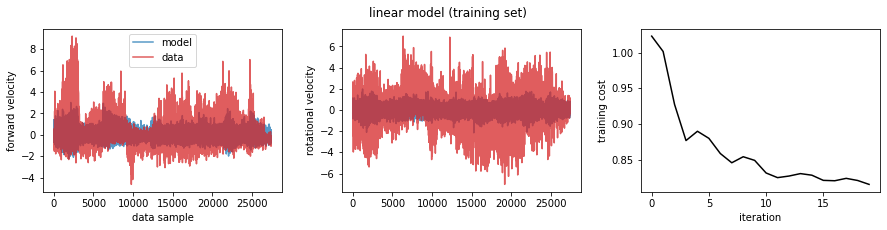

training mean-squared error: 0.004
training median-absolute deviation: 0.386


In [16]:
# Get the outputs from the test data.
predictions = []

for data in train_loader:
    supervoxel,y = data
    supervoxel = supervoxel.float().to(device)
    prediction = model(supervoxel).cpu().detach().numpy()
    predictions.append(prediction)

predictions = np.vstack(predictions)

fig,ax = plt.subplots(1,3,figsize=(15,3))
fig.subplots_adjust(wspace=.25)
ax[0].plot(predictions[:,0],c='C0',alpha=.75,label='model')
ax[0].plot(train_dataset.Y[:,0],c='C3',alpha=.75,label='data')
ax[0].set_xlabel('data sample')
ax[0].set_ylabel('forward velocity')
ax[0].legend()

ax[1].plot(predictions[:,1],c='C0',alpha=.75)
ax[1].plot(train_dataset.Y[:,1],c='C3',alpha=.75)
ax[1].set_ylabel('rotational velocity')

ax[2].plot(cost_cache,c='k')
ax[2].set_xlabel('iteration')
ax[2].set_ylabel('training cost')

plt.suptitle('linear model (training set)')
plt.savefig('./linear_training_result.pdf')
plt.show()

# Compute the error and print it out.
training_mse = (1 / np.product(predictions.shape)) * linalg.norm(predictions - train_dataset.Y)
training_mad = np.median(np.abs(predictions.ravel() - train_dataset.Y.ravel()))
print("training mean-squared error: %.3f"%training_mse)
print("training median-absolute deviation: %.3f"%training_mad)

## Predict on the test data

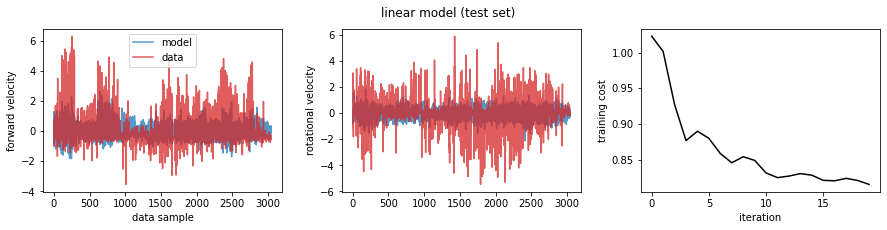

testing mean-squared error: 0.012
testing median-absolute deviation: 0.394


In [17]:
# Get the outputs from the test data.
predictions = []

for data in test_loader:
    supervoxel,y = data
    supervoxel = supervoxel.float().to(device)
    prediction = model(supervoxel).cpu().detach().numpy()
    predictions.append(prediction)

predictions = np.vstack(predictions)

fig,ax = plt.subplots(1,3,figsize=(15,3))
fig.subplots_adjust(wspace=.25)
ax[0].plot(predictions[:,0],c='C0',alpha=.75,label='model')
ax[0].plot(test_dataset.Y[:,0],c='C3',alpha=.75,label='data')
ax[0].set_xlabel('data sample')
ax[0].set_ylabel('forward velocity')
ax[0].legend()

ax[1].plot(predictions[:,1],c='C0',alpha=.75)
ax[1].plot(test_dataset.Y[:,1],c='C3',alpha=.75)
ax[1].set_ylabel('rotational velocity')

ax[2].plot(cost_cache,c='k')
ax[2].set_xlabel('iteration')
ax[2].set_ylabel('training cost')

plt.suptitle('linear model (test set)')
plt.savefig('./linear_test_result.pdf')
plt.show()

# Compute the error and print it out.
testing_mse = (1 / np.product(predictions.shape)) * linalg.norm(predictions - test_dataset.Y)
testing_mad = np.median(np.abs(predictions.ravel() - test_dataset.Y.ravel()))
print("testing mean-squared error: %.3f"%testing_mse)
print("testing median-absolute deviation: %.3f"%testing_mad)

## Define a 3 layer neural network

In [18]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.linear1 = nn.Linear(2000, 256)

        self.linear2 = nn.Linear(256, 128)
        
        self.linear3 = nn.Linear(128, 2)
        
    def forward(self, x):
        
        x = F.relu(self.linear1(x))
        
        x = nn.Dropout(p=.2)(x)

        x = F.relu(self.linear2(x))
        
        x = self.linear3(x)
        
        return x

model = Model()
    
# Define the loss function as MSE loss
criterion = nn.MSELoss()

# Define the optimizer with a learning rate
optimizer = optim.Adam(model.parameters(), lr=ALPHA,weight_decay=1e-5)
model = model.to(device)

## Train the model

In [19]:
start_time = time.time()

# Number of training epochs
N_EPOCHS = 125
cost_cache = []

for epoch in range(N_EPOCHS): 
    
      for i, (supervoxel, y) in enumerate(train_loader, 0):
        
        supervoxel = supervoxel.float().to(device)
        y = y.float().to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward propogation
        outputs = model(supervoxel)
        
        # calculate the loss
        loss = criterion(outputs, y)
        
        # backpropogation + update parameters
        loss.backward()
        optimizer.step()

        # print statistics
        cost = loss.item()
        cost_cache.append(cost)
        if epoch % 10 == 0 and i % 100 == 0:    # print every 1000 iterations
            print('Epoch:' + str(epoch) + ", Iteration: " + str(i) 
                  + ", training cost = " + str(cost))
            
print("--- %s seconds ---" % (time.time() - start_time))

Epoch:0, Iteration: 0, training cost = 1.0045942068099976
Epoch:10, Iteration: 0, training cost = 0.859620213508606
Epoch:20, Iteration: 0, training cost = 0.7063312530517578
Epoch:30, Iteration: 0, training cost = 0.5539090633392334
Epoch:40, Iteration: 0, training cost = 0.3966638743877411
Epoch:50, Iteration: 0, training cost = 0.2895734906196594
Epoch:60, Iteration: 0, training cost = 0.2198719084262848
Epoch:70, Iteration: 0, training cost = 0.17109474539756775
Epoch:80, Iteration: 0, training cost = 0.14261658489704132
Epoch:90, Iteration: 0, training cost = 0.12006936967372894
Epoch:100, Iteration: 0, training cost = 0.10410289466381073
Epoch:110, Iteration: 0, training cost = 0.09133090823888779
Epoch:120, Iteration: 0, training cost = 0.08385837078094482
--- 233.04372477531433 seconds ---


## Predict training data and get the MSE and MAD

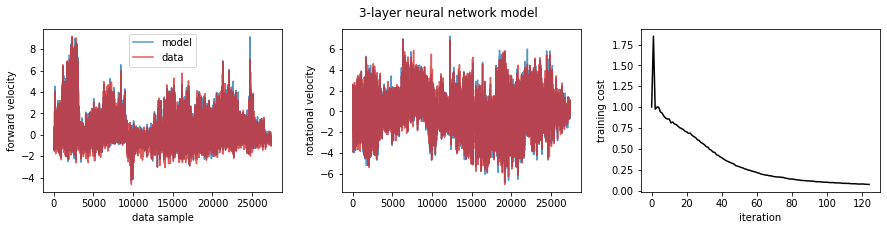

training mean-squared error: 0.001
training median-absolute deviation: 0.122


In [20]:
# Get the outputs from the test data.
predictions = []

for data in train_loader:
    supervoxel,y = data
    supervoxel = supervoxel.float().to(device)
    prediction = model(supervoxel).cpu().detach().numpy()
    predictions.append(prediction)

predictions = np.vstack(predictions)

fig,ax = plt.subplots(1,3,figsize=(15,3))
fig.subplots_adjust(wspace=.25)
ax[0].plot(predictions[:,0],c='C0',alpha=.75,label='model')
ax[0].plot(train_dataset.Y[:,0],c='C3',alpha=.75,label='data')
ax[0].set_xlabel('data sample')
ax[0].set_ylabel('forward velocity')
ax[0].legend()

ax[1].plot(predictions[:,1],c='C0',alpha=.75)
ax[1].plot(train_dataset.Y[:,1],c='C3',alpha=.75)
ax[1].set_ylabel('rotational velocity')

ax[2].plot(cost_cache,c='k')
ax[2].set_xlabel('iteration')
ax[2].set_ylabel('training cost')

plt.suptitle('3-layer neural network model')
plt.savefig('./nn_training_result.pdf')
plt.show()

# Compute the error and print it out.
training_mse = (1 / np.product(predictions.shape)) * linalg.norm(predictions - train_dataset.Y)
training_mad = np.median(np.abs(predictions.ravel() - train_dataset.Y.ravel()))
print("training mean-squared error: %.3f"%training_mse)
print("training median-absolute deviation: %.3f"%training_mad)

## Predict on the test data

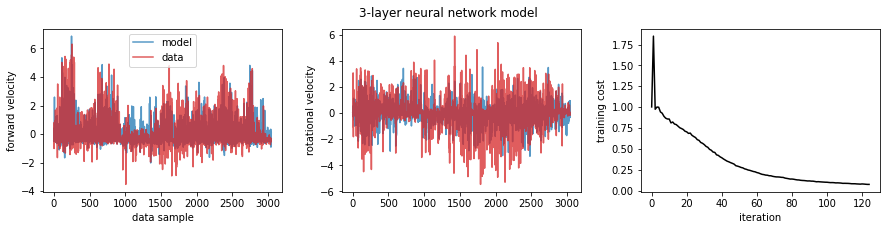

testing mean-squared error: 0.013
testing median-absolute deviation: 0.265


In [22]:
# Get the outputs from the test data.
predictions = []

for data in test_loader:
    supervoxel,y = data
    supervoxel = supervoxel.float().to(device)
    prediction = model(supervoxel).cpu().detach().numpy()
    predictions.append(prediction)

predictions = np.vstack(predictions)

fig,ax = plt.subplots(1,3,figsize=(15,3))
fig.subplots_adjust(wspace=.25)
ax[0].plot(predictions[:,0],c='C0',alpha=.75,label='model')
ax[0].plot(test_dataset.Y[:,0],c='C3',alpha=.75,label='data')
ax[0].set_xlabel('data sample')
ax[0].set_ylabel('forward velocity')
ax[0].legend()

ax[1].plot(predictions[:,1],c='C0',alpha=.75)
ax[1].plot(test_dataset.Y[:,1],c='C3',alpha=.75)
ax[1].set_ylabel('rotational velocity')

ax[2].plot(cost_cache,c='k')
ax[2].set_xlabel('iteration')
ax[2].set_ylabel('training cost')

plt.suptitle('3-layer neural network model')
plt.savefig('./nn_test_result.pdf')
plt.show()

# Compute the error and print it out.
testing_mse = (1 / np.product(predictions.shape)) * linalg.norm(predictions - test_dataset.Y)
testing_mad = np.median(np.abs(predictions.ravel() - test_dataset.Y.ravel()))
print("testing mean-squared error: %.3f"%testing_mse)
print("testing median-absolute deviation: %.3f"%testing_mad)